Code adapted from:

https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

# Encoder Classification & Decoder Classification

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),            
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.decoder(x)
        return x.view(-1, 1, 28, 28)

In [5]:
class EncodingClassifier(nn.Module):
    def __init__(self):
        super(EncodingClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

class DecodingClassifier(nn.Module):
    def __init__(self):
        super(DecodingClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [6]:
# Instantiate models
encoder = Encoder()
decoder = Decoder()
encoding_classifier = EncodingClassifier()
decoding_classifier = DecodingClassifier()

# Loss function and optimizer
classification_criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()

optimizer = torch.optim.SGD(list(encoder.parameters()) + 
                      list(decoder.parameters()) +
                      list(encoding_classifier.parameters()) + 
                      list(decoding_classifier.parameters()), lr=0.01, momentum=0.9)


In [7]:
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass through encoder and decoder
        encoded = encoder(images)
        decoded = decoder(encoded)
        
        # Classification on encoded representations
        encoding_outputs = encoding_classifier(encoded)
        encoding_loss = classification_criterion(encoding_outputs, labels)
        
        # Classification on decoded images
        decoding_outputs = decoding_classifier(decoded)
        decoding_loss = classification_criterion(decoding_outputs, labels)
        
        # Reconstruction loss
        reconstruction_loss = reconstruction_criterion(decoded, images)
        
        # Combined loss
        loss = encoding_loss + decoding_loss + reconstruction_loss
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/5], Loss: 1.3498
Epoch [2/5], Loss: 0.3855
Epoch [3/5], Loss: 0.3276
Epoch [4/5], Loss: 0.1681
Epoch [5/5], Loss: 0.2316


In [8]:
encoder.eval()
encoding_classifier.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        encoded = encoder(images)
        outputs = encoding_classifier(encoded)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

encoding_accuracy = 100 * correct / total
print(f"Encoding Classifier Test Accuracy: {encoding_accuracy:.2f}%")

Encoding Classifier Test Accuracy: 97.32%


In [9]:
decoder.eval()
decoding_classifier.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        encoded = encoder(images)
        decoded = decoder(encoded)
        outputs = decoding_classifier(decoded)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

decoding_accuracy = 100 * correct / total
print(f"Decoding Classifier Test Accuracy: {decoding_accuracy:.2f}%")

Decoding Classifier Test Accuracy: 96.97%


# UMAP

UMAP code adapted from:

https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_mnist_example.html

In [11]:
import umap

# Initialize UMAP reducer to reduce data to 2D
reducer = umap.UMAP(n_components=2, random_state=42)

# Gather all encodings and decodings from the test set
all_encodings = []
all_decodings = []
all_labels = []

# Disable gradients for evaluation
encoder.eval()
decoder.eval()
encoding_classifier.eval()
decoding_classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        # Encode images and decode the encodings
        encodings = encoder(images)
        decodings = decoder(encodings)

        # Collect encodings, decodings, and true labels
        all_encodings.append(encodings.cpu())
        all_decodings.append(decodings.cpu())
        all_labels.append(labels.cpu())

# Concatenate all encodings, decodings, and labels into single tensors
all_encodings = torch.cat(all_encodings)  # Shape: (num_samples, encoding_dim)
all_decodings = torch.cat(all_decodings)  # Shape: (num_samples, decoding_dim)
all_labels = torch.cat(all_labels).numpy()  # Convert labels to numpy array

# Flatten encodings and decodings to 2D arrays
all_encodings = all_encodings.view(all_encodings.shape[0], -1).numpy()  # Shape (num_samples, flattened_dims)
all_decodings = all_decodings.view(all_decodings.shape[0], -1).numpy()  # Shape (num_samples, flattened_dims)

# Apply UMAP reduction on encodings and decodings
umap_encodings = reducer.fit_transform(all_encodings)
umap_decodings = reducer.fit_transform(all_decodings)

# Convert UMAP outputs to torch tensors for use in PyTorch classifiers
umap_encodings = torch.tensor(umap_encodings, dtype=torch.float32)
umap_decodings = torch.tensor(umap_decodings, dtype=torch.float32)


/home/david/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/david/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Receptive Field

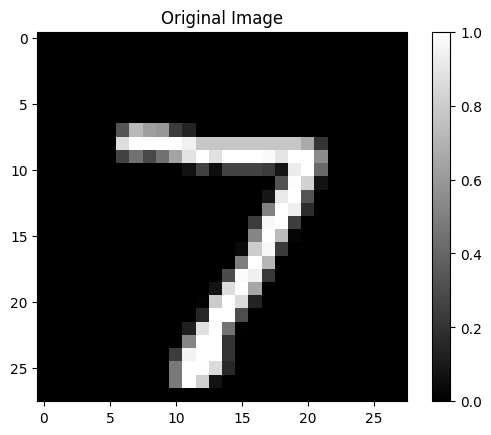

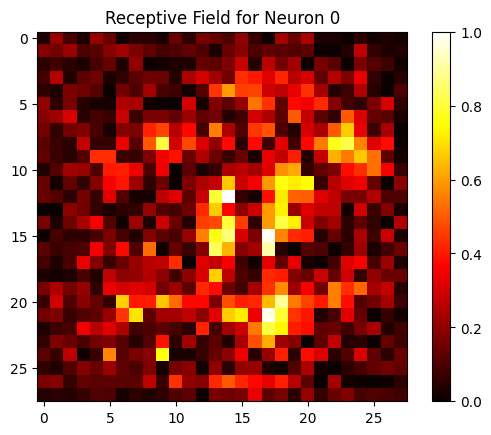

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_receptive_field(model, image, target_neuron_idx):
    model.eval()

    image = image.clone().detach()
    image.requires_grad = True

    output = model(image)
    
    # Select the target neuron in the output layer
    target_neuron = output[0, target_neuron_idx]
    
    # Perform backward pass from target neuron
    target_neuron.backward(retain_graph=True)

    # Extract gradients from the image
    gradients = image.grad.data[0].cpu().numpy()
    heatmap = np.abs(gradients).mean(axis=0)
    
    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # Plot heatmap overlayed on the original image
    plt.imshow(heatmap, cmap='hot')
    plt.title(f'Receptive Field for Neuron {target_neuron_idx}')
    plt.colorbar()
    plt.show()

image, _ = next(iter(test_loader))
image = image[0:1].to('cpu')

plt.imshow(image[0][0], cmap='gray')
plt.title('Original Image')
plt.colorbar()
plt.show()


visualize_receptive_field(encoder, image, target_neuron_idx=0)

